# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов.  
В нём можно быстро узнать рыночную стоимость своего автомобиля.
В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

Задача получить значение метрики RMSE менее 2200

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка данных

## Импорт библиотек

In [1]:
!pip install missingno -q

In [2]:
!pip install cmake -q

In [3]:
!pip install lightgbm -q

In [4]:
!pip install CatBoost -q

In [5]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error as rmse
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns

## Импорт данных

## Первый взгляд на данные

In [7]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

# Обработка данных

In [9]:
# функция по выводу первичной информации о столбце
def data_info(column_to_info):
    print(f'Info for {column_to_info}')
    print(data[column_to_info].info())
    print('***************')
    print()
    print('***************')
    print(f'Describe for {column_to_info}')
    print(data[column_to_info].describe())
    print('***************')
    print()
    print('***************')
    print(f'Missing values for {column_to_info}')
    print(data[column_to_info].isna().mean()*100)
    print('***************')


## Обработка наименований столбцов

Приведем наименование столбцов к нижнему регистру и разделением между словами

In [10]:
data.columns = data.columns.str.lower()
data = data.rename(columns={'datecrawled': 'date_crawled',
                            'vehicletype': 'vehicle_type',
                            'registrationyear': 'registration_year',
                            'registrationmonth': 'registration_month',
                            'fueltype': 'fuel_type',
                            'datecreated': 'date_created',
                            'numberofpictures': 'number_of_pictures',
                            'postalcode': 'postal_code',
                            'lastseen': 'last_seen'})
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

## Работа со столбцом date_crawled

### data_info('date_crawled')

In [11]:
# перевод типа столбца в дату
# data.date_crawled = pd.to_datetime(data.date_crawled)

In [12]:
data.date_crawled.info()

<class 'pandas.core.series.Series'>
RangeIndex: 354369 entries, 0 to 354368
Series name: date_crawled
Non-Null Count   Dtype 
--------------   ----- 
354369 non-null  object
dtypes: object(1)
memory usage: 2.7+ MB


## Работа со столбцом price

In [13]:
data_info('price')

Info for price
<class 'pandas.core.series.Series'>
RangeIndex: 354369 entries, 0 to 354368
Series name: price
Non-Null Count   Dtype
--------------   -----
354369 non-null  int64
dtypes: int64(1)
memory usage: 2.7 MB
None
***************

***************
Describe for price
count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64
***************

***************
Missing values for price
0.0
***************


Из описания стоит обратить внимание на то, что цена у некоторых автомобилей равна `0`

In [14]:
print(f'Количество значений 0: {(data.price == 0).sum()} | {(data.price == 0).mean()*100}%')

Количество значений 0: 10772 | 3.0397692800442475%


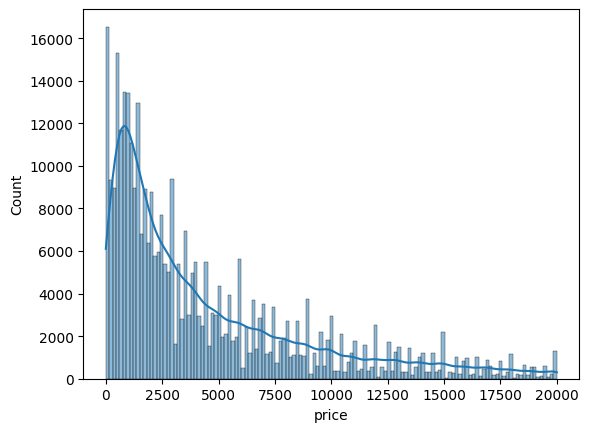

In [15]:
%matplotlib inline
sns.histplot(data=data['price'], kde=True)
plt.show()

Из графика видно, что распределение имеет логарифмическое распределение

Посмотрим на строки, где стоимость машины равно `0`

In [16]:
data.loc[data.price == 0]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0,27432,2016-03-12 23:47:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354205,2016-03-09 15:56:30,0,NaN,2000,manual,65,corsa,150000,0,NaN,opel,yes,2016-03-09 00:00:00,0,23758,2016-03-30 11:16:08
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,2016-03-20 00:00:00,0,33659,2016-04-06 18:45:23
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,2016-03-24 00:00:00,0,42329,2016-04-07 05:17:24
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10 00:00:00,0,22559,2016-03-12 23:46:32


Исключим 3% данных в которых цена = 0

In [17]:
data = data.loc[data.price != 0]

## Работа со столбцами vehicle_type, model, brand

Данные столбцы целесообразно рассматривать совокупно

In [18]:
print(f'''Пропуски в столбцах:
Vehicle_type: {data.vehicle_type.isna().mean()*100}%
Model: {data.model.isna().mean()*100}%
brand: {data.brand.isna().mean()*100}%
''')

Пропуски в столбцах:
Vehicle_type: 9.822553747558914%
Model: 5.099287828473473%
brand: 0.0%



Сначала уберем пропуски, когда у нас есть информация о бренде и модели машины, но нет о типе кузова. Замена будет производиться по самой популярной модели. Замена не идеальна, так как одна модель может иметь разные варианты исполнения, но лучше пропусков.

In [19]:
data.model = data['model'].fillna('temp')

In [20]:
data.vehicle_type = data['vehicle_type'].fillna('temp')

In [21]:
for model in data.model.unique():
    data.loc[data['vehicle_type'] == 'temp', 'vehicle_type'] =\
    data.loc[data['model'] == model, 'vehicle_type'].value_counts().idxmax()

In [22]:
#проверка замены типа кузова
data.vehicle_type.unique()

array(['sedan', 'coupe', 'suv', 'small', 'convertible', 'bus', 'wagon',
       'other'], dtype=object)

Данная замена позволила полностью избавиться от пустых значений в столбце `vehicle_type`

Проведем подобную замену в обратную сторону для отсутствующих значениях в столбце 'model'

In [23]:
for brand in data.brand.unique():
    for veh_type in data.vehicle_type.unique():
        try:
            data.loc[data['model'] == 'temp', 'model'] =\
                data.loc[(data['vehicle_type'] == veh_type)&(data['brand'] == brand), 'model'].value_counts().idxmax()
        except:
            data.loc[data['model'] == 'temp', 'model'] = 'unknown model'

In [24]:
#проверим была ли ошибка в цикле при замене пропущенных значений в модели
data.loc[data['model'] == 'unknown model']

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen


In [25]:
data.model.unique()

array(['golf', 'grand', 'fabia', '3er', '2_reihe', 'c_max', '3_reihe',
       'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse', 'scirocco',
       '5er', 'meriva', 'arosa', 'other', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'one', 'fortwo',
       '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta', 'fiesta',
       'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'corsa', 'a6', 'jazz', 'omega', 'slk', '7er', '80',
       '147', '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza',
       'mustang', 'eos', 'touran', 'getz', 'a3', 'almera', 'megane',
       'lupo', 'r19', 'zafira', 'caddy', 'mondeo', 'cordoba', 'colt',
       'impreza', 'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace',
       'sharan', '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe',
       'yeti', 'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox',
   

Получилось избавиться от всех пропусков значений в модели машины

## Работа со столбцом registration_year, registration_months

### Обработка столбца года

In [26]:
data_info('registration_year')

Info for registration_year
<class 'pandas.core.series.Series'>
Int64Index: 343597 entries, 0 to 354368
Series name: registration_year
Non-Null Count   Dtype
--------------   -----
343597 non-null  int64
dtypes: int64(1)
memory usage: 5.2 MB
None
***************

***************
Describe for registration_year
count    343597.000000
mean       2004.089797
std          78.413225
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64
***************

***************
Missing values for registration_year
0.0
***************


В столбце года регистрации имеется выброс значений.

In [27]:
int(data.registration_year.quantile(0.05))

1993

In [28]:
int(data.registration_year.quantile(0.95))

2016

Заменим все значения выходящие за границы 5 и 95 квантили на предельные значения этих квантилей. Для 5-й квантили отнимем еще 10 лет, так как в продаже могут быть машины, которые давно стоят на учете

In [29]:
data.loc[data.registration_year < data.registration_year.quantile(0.05), 'registration_year'] = data.registration_year.quantile(0.05) - 10
data.loc[data.registration_year > data.registration_year.quantile(0.95), 'registration_year'] = data.registration_year.quantile(0.95)

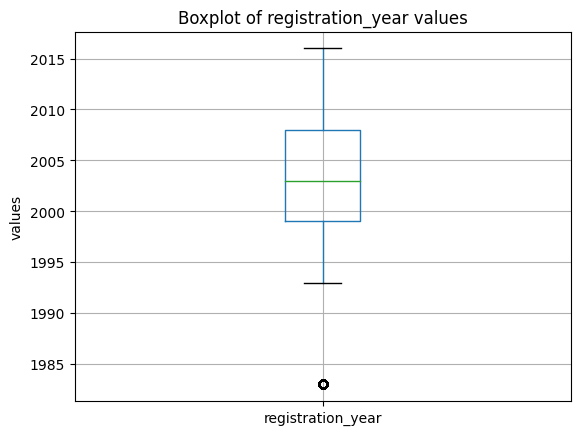

In [30]:
data.boxplot(column='registration_year')
plt.title('Boxplot of registration_year values')
plt.ylabel('values')
plt.show()

### Обработка столбца месяца

In [31]:
data_info('registration_month')

Info for registration_month
<class 'pandas.core.series.Series'>
Int64Index: 343597 entries, 0 to 354368
Series name: registration_month
Non-Null Count   Dtype
--------------   -----
343597 non-null  int64
dtypes: int64(1)
memory usage: 5.2 MB
None
***************

***************
Describe for registration_month
count    343597.000000
mean          5.777891
std           3.698186
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registration_month, dtype: float64
***************

***************
Missing values for registration_month
0.0
***************


In [32]:
data.loc[data['registration_month'] == 0]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06
15,2016-03-11 21:39:15,450,small,1983,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
16,2016-04-01 12:46:46,300,sedan,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46
36,2016-03-11 11:50:37,1600,other,1983,manual,75,kadett,70000,0,NaN,opel,NaN,2016-03-11 00:00:00,0,2943,2016-04-07 03:46:09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354305,2016-04-03 13:46:24,3500,sedan,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN,2016-04-03 00:00:00,0,74579,2016-04-05 12:44:38
354318,2016-03-15 19:57:11,400,wagon,1983,manual,0,legacy,150000,0,petrol,subaru,NaN,2016-03-15 00:00:00,0,24558,2016-03-19 15:49:00
354326,2016-03-31 19:36:18,1300,small,1999,manual,75,2_reihe,125000,0,NaN,peugeot,NaN,2016-03-31 00:00:00,0,35102,2016-04-06 13:44:44
354329,2016-03-30 20:55:30,350,small,1996,NaN,65,punto,150000,0,NaN,fiat,NaN,2016-03-30 00:00:00,0,25436,2016-04-07 13:50:41


Месяца "0" не существует, видимо при миграции данных была допущена ошибка, предлагаю заменить нулевой месяц регистрации автомобиля медианным значением.

In [33]:
data.loc[data['registration_month'] == 0, 'registration_month'] = data.loc[data['registration_month'] != 0, 'registration_month'].median()

In [34]:
data.registration_month.describe()

count    343597.000000
mean          6.352069
std           3.186985
min           1.000000
25%           4.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registration_month, dtype: float64

## Работа со столбцом gearbox

In [35]:
data_info('gearbox')

Info for gearbox
<class 'pandas.core.series.Series'>
Int64Index: 343597 entries, 0 to 354368
Series name: gearbox
Non-Null Count   Dtype 
--------------   ----- 
326242 non-null  object
dtypes: object(1)
memory usage: 5.2+ MB
None
***************

***************
Describe for gearbox
count     326242
unique         2
top       manual
freq      261373
Name: gearbox, dtype: object
***************

***************
Missing values for gearbox
5.0509754159669615
***************


In [36]:
data.gearbox.value_counts()

manual    261373
auto       64869
Name: gearbox, dtype: int64

Заменим пропущенные значения в столбцe на самые популярные значения для данной модели

In [37]:
for brand in data.brand.unique():
    for veh_type in data.vehicle_type.unique():
        try:
            data.loc[data.gearbox.isna(), 'gearbox'] =\
                data.loc[(data['vehicle_type'] == veh_type)&(data['brand'] == brand), 'gearbox'].value_counts().idxmax()
        except:
            data.loc[data['model'] == 'temp', 'model'] = 'unknown gearbox'

## Работа со столбцом power

In [38]:
data_info('power')

Info for power
<class 'pandas.core.series.Series'>
Int64Index: 343597 entries, 0 to 354368
Series name: power
Non-Null Count   Dtype
--------------   -----
343597 non-null  int64
dtypes: int64(1)
memory usage: 5.2 MB
None
***************

***************
Describe for power
count    343597.000000
mean        111.000192
std         188.177974
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64
***************

***************
Missing values for power
0.0
***************


Пропусков в данном столбце нет, но видим значения мощности равные 0.

Количество лошадиных сил регламентировано в каждой модели, так же логично.
Из личного опыта, исключать выбросы буду для машин, ЛС которых менее 100 и более 300. Так как в разных исполнениях, количество ЛС могут быть разное, то в таком случае замену подставлять будем по усредненному значению между всеми вариантам данной модели.

In [39]:
data.loc[data['model'] == 'ka', 'power'].median()

60.0

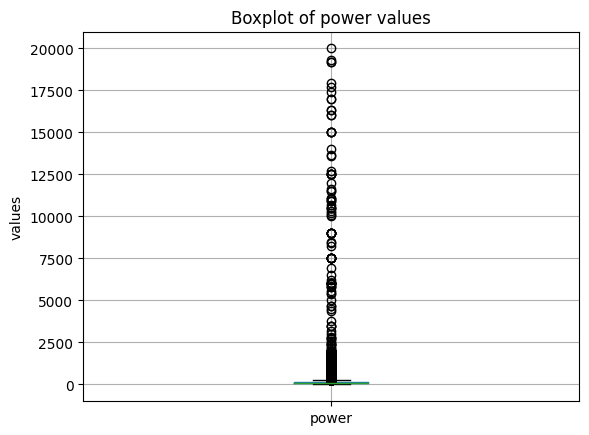

In [40]:
data.boxplot(column='power')
plt.title('Boxplot of power values')
plt.ylabel('values')
plt.show()

In [41]:
for model in data.model.unique():
    data.loc[(data['power'] < 100)|(data['power'] > 300)&(data['model'] == model), 'power'] =\
    data.loc[(data['power'] > 100)&(data['power'] < 300)&(data['model'] == model), 'power'].mean()

In [42]:
data.loc[(data['power'] > 100)&(data['power'] < 300)&(data['model'] == 'golf'), 'power'].mean()

133.9658111426783

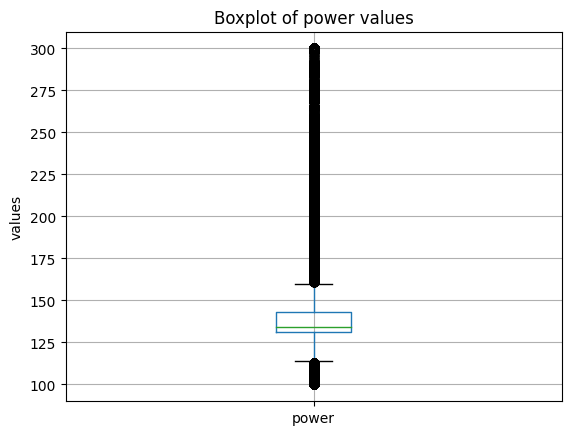

In [43]:
data.boxplot(column='power')
plt.title('Boxplot of power values')
plt.ylabel('values')
plt.show()

## Работа со столбцом kilometer

In [44]:
data_info('kilometer')

Info for kilometer
<class 'pandas.core.series.Series'>
Int64Index: 343597 entries, 0 to 354368
Series name: kilometer
Non-Null Count   Dtype
--------------   -----
343597 non-null  int64
dtypes: int64(1)
memory usage: 5.2 MB
None
***************

***************
Describe for kilometer
count    343597.000000
mean     128337.616452
std       37521.047429
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64
***************

***************
Missing values for kilometer
0.0
***************


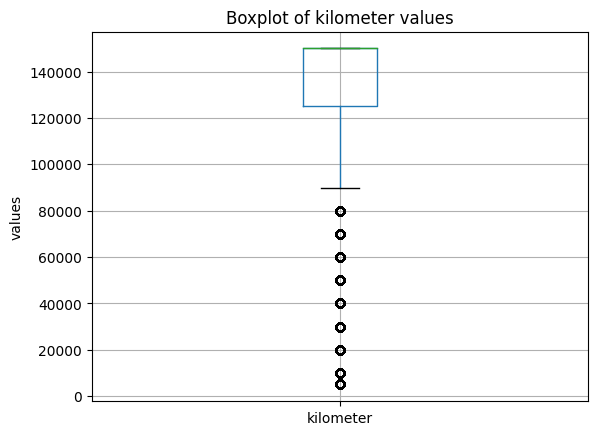

In [45]:
data.boxplot(column='kilometer')
plt.title('Boxplot of kilometer values')
plt.ylabel('values')
plt.show()

## Работа со столбцом fuel_type

In [46]:
data_info('fuel_type')

Info for fuel_type
<class 'pandas.core.series.Series'>
Int64Index: 343597 entries, 0 to 354368
Series name: fuel_type
Non-Null Count   Dtype 
--------------   ----- 
314138 non-null  object
dtypes: object(1)
memory usage: 5.2+ MB
None
***************

***************
Describe for fuel_type
count     314138
unique         7
top       petrol
freq      210765
Name: fuel_type, dtype: object
***************

***************
Missing values for fuel_type
8.573706988128535
***************


In [47]:
for brand in data.brand.unique():
    for veh_type in data.vehicle_type.unique():
        try:
            data.loc[data.fuel_type.isna(), 'fuel_type'] =\
                data.loc[(data['vehicle_type'] == veh_type)&(data['brand'] == brand), 'fuel_type'].value_counts().idxmax()
        except:
            data.loc[data.fuel_type.isna(), 'fuel_type'] = 'unknown fuel_type'

In [48]:
data.fuel_type.value_counts()

petrol      240224
gasoline     97168
lpg           5166
cng            554
hybrid         227
other          170
electric        88
Name: fuel_type, dtype: int64

## Работа со столбцом repaired

In [49]:
data_info('repaired')

Info for repaired
<class 'pandas.core.series.Series'>
Int64Index: 343597 entries, 0 to 354368
Series name: repaired
Non-Null Count   Dtype 
--------------   ----- 
277731 non-null  object
dtypes: object(1)
memory usage: 5.2+ MB
None
***************

***************
Describe for repaired
count     277731
unique         2
top           no
freq      243682
Name: repaired, dtype: object
***************

***************
Missing values for repaired
19.169550374421195
***************


Так как нет прямой зависимости ремонта от других параметров, предлагаю заменить пропущенные значения на заглушку (категорию) `NA`.

In [50]:
data.repaired = data.repaired.fillna('NA')

## Работа со столбцом date_created

In [51]:
data_info('date_created')

Info for date_created
<class 'pandas.core.series.Series'>
Int64Index: 343597 entries, 0 to 354368
Series name: date_created
Non-Null Count   Dtype 
--------------   ----- 
343597 non-null  object
dtypes: object(1)
memory usage: 5.2+ MB
None
***************

***************
Describe for date_created
count                  343597
unique                    109
top       2016-04-03 00:00:00
freq                    13342
Name: date_created, dtype: object
***************

***************
Missing values for date_created
0.0
***************


## Работа со столбцом number_of_pictures

In [52]:
data_info('number_of_pictures')

Info for number_of_pictures
<class 'pandas.core.series.Series'>
Int64Index: 343597 entries, 0 to 354368
Series name: number_of_pictures
Non-Null Count   Dtype
--------------   -----
343597 non-null  int64
dtypes: int64(1)
memory usage: 5.2 MB
None
***************

***************
Describe for number_of_pictures
count    343597.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: number_of_pictures, dtype: float64
***************

***************
Missing values for number_of_pictures
0.0
***************


при выгрузке базы данных, столбец `number_of_pictures` был перенесен некорреткно, так как все значения столбцы равны `0`, целесообразно данный столбец исключить.

*в условиях реальной задачи, имеет смысл создать тикет на корректировка базы данных*

In [53]:
data = data.drop('number_of_pictures', axis=1)

## Работа со столбцом postal_code

In [54]:
data_info('postal_code')

Info for postal_code
<class 'pandas.core.series.Series'>
Int64Index: 343597 entries, 0 to 354368
Series name: postal_code
Non-Null Count   Dtype
--------------   -----
343597 non-null  int64
dtypes: int64(1)
memory usage: 5.2 MB
None
***************

***************
Describe for postal_code
count    343597.000000
mean      50683.358915
std       25744.205799
min        1067.000000
25%       30449.000000
50%       49525.000000
75%       71229.000000
max       99998.000000
Name: postal_code, dtype: float64
***************

***************
Missing values for postal_code
0.0
***************


In [55]:
pd.DataFrame(data.postal_code.value_counts())

,postal_code
10115,812
65428,604
66333,327
32257,305
44145,303
...,...
16918,1
29473,1
12625,1
38879,1


Столбец postal_code больше носит категориальный смысл, так как обозначает регион продажи автомобиля, вносить изменения не буду.

## Работа со столбцом last_seen

In [56]:
data_info('last_seen')

Info for last_seen
<class 'pandas.core.series.Series'>
Int64Index: 343597 entries, 0 to 354368
Series name: last_seen
Non-Null Count   Dtype 
--------------   ----- 
343597 non-null  object
dtypes: object(1)
memory usage: 5.2+ MB
None
***************

***************
Describe for last_seen
count                  343597
unique                 174543
top       2016-04-07 13:17:48
freq                       16
Name: last_seen, dtype: object
***************

***************
Missing values for last_seen
0.0
***************


In [57]:
# перевод типа столбца в дату
data.last_seen = pd.to_datetime(data.last_seen)

## Выводы по разделу

В ходе предобработки данных были выполнены мероприятия:
- Изменен тип столбцов на тип даты:
    - data_crawled
    - last_seen
- В столбце `price` исключены строки с нулевым значением
- На основании самых популярных значений были заполнены пропуски в столбцах:
    - vehicle_type
    - brand
    - model
    - gearbox
    - fuel_type
- В столбце `registration_year` года ограничены по 5 и 95 квантили, для нижней границы добавлены 10 лет
- В столбце `registration_month` значения месяца 0 заменены на медианное значение остальных значений (исключив строки с 0 значением)
- В столбце `power` обработаны значения менее 100 и более 300 лс, на популярные значения для каждой модели.

In [58]:
data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen
0,2016-03-24 11:52:17,480,sedan,1993,manual,133.965811,golf,150000,6,petrol,volkswagen,NA,2016-03-24 00:00:00,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190.000000,golf,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163.000000,grand,125000,8,gasoline,jeep,NA,2016-03-14 00:00:00,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,133.965811,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,133.965811,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,60437,2016-04-06 10:17:21


# Обучение моделей

## Подготовка выборок

В нашем распоряжении достаточно объемный датасет, поэтому мы можем позволить себе разбить его на три выборки: трейновую, валидационную и тестовую. Кросс-валидацию в данном кейсе считаем избыточной, поскольку она на таком объемном датасете будет тратить много времени, особенно на моделях градиентного бустинга.

In [59]:
data = data.drop(['date_crawled', 'registration_month', 'date_created', 'postal_code', 'last_seen'], axis=1)
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,sedan,1993,manual,133.965811,golf,150000,petrol,volkswagen,NA
1,18300,coupe,2011,manual,190.000000,golf,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163.000000,grand,125000,gasoline,jeep,NA
3,1500,small,2001,manual,133.965811,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,133.965811,fabia,90000,gasoline,skoda,no


In [60]:
train, valid, test = np.split(data.sample(frac=1, random_state=321), [int(.6*len(data)), int(.8*len(data))])
print(train.shape)
print(valid.shape)
print(test.shape)

(206158, 10)
(68719, 10)
(68720, 10)


In [61]:
features_train = train.drop(['price'], axis=1)
target_train = train['price']
features_valid = valid.drop(['price'], axis=1)
target_valid = valid['price']
features_test = test.drop(['price'], axis=1)
target_test = test['price']

Выделим в отдельные списки категориальные и количественные признаки.

In [62]:
cat_features = ['vehicle_type', 'registration_year', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
num_features = ['power', 'kilometer']

## CatBoost

In [63]:
results = {}

In [64]:
#подбор гиперпараметров для CatBoost

params = {'iterations': [50,100,200],
          'depth': [1, 2, 3],
          'learning_rate':[0.2, 0.3, 0.4] }

catboost_cv = RandomizedSearchCV(estimator=CatBoostRegressor(cat_features=cat_features, verbose = 300),
                                 param_distributions=params,
                                 scoring='neg_mean_squared_error',
                                 cv=3, n_iter=15, random_state=321)

catboost_cv.fit(features_train, target_train)

catboost_model = catboost_cv.best_estimator_

0:	learn: 4174.2594615	total: 85.4ms	remaining: 4.18s
49:	learn: 2483.6663615	total: 984ms	remaining: 0us
0:	learn: 4175.1255403	total: 32.5ms	remaining: 1.59s
49:	learn: 2482.6536896	total: 927ms	remaining: 0us
0:	learn: 4187.3971073	total: 32ms	remaining: 1.57s
49:	learn: 2489.2087746	total: 961ms	remaining: 0us
0:	learn: 3617.8475918	total: 50.1ms	remaining: 4.96s
99:	learn: 1980.4391753	total: 4.37s	remaining: 0us
0:	learn: 3631.1688681	total: 45.4ms	remaining: 4.5s
99:	learn: 1964.6140723	total: 4.17s	remaining: 0us
0:	learn: 3650.3692110	total: 43.6ms	remaining: 4.32s
99:	learn: 1974.8941855	total: 3.08s	remaining: 0us
0:	learn: 4069.2772185	total: 58.3ms	remaining: 11.6s
199:	learn: 2040.3834120	total: 8.14s	remaining: 0us
0:	learn: 4074.6791829	total: 60.4ms	remaining: 12s
199:	learn: 2029.5967993	total: 7.55s	remaining: 0us
0:	learn: 4087.3974176	total: 119ms	remaining: 23.8s
199:	learn: 2033.4989169	total: 6.72s	remaining: 0us
0:	learn: 4069.2772185	total: 39.9ms	remaining: 3

In [65]:
%%time
# посмотрим на скорость обучения модели
catboost_model.fit(features_train, target_train)

0:	learn: 3769.2573441	total: 149ms	remaining: 29.6s
199:	learn: 1896.1969064	total: 18.7s	remaining: 0us
CPU times: user 32.2 s, sys: 575 ms, total: 32.8 s
Wall time: 19.2 s


In [66]:
%%time
# посмотрим на результаты модели на валидационной выборке
preds = catboost_model.predict(features_valid)

rmse = mean_squared_error(target_valid, preds, squared=False)
results['CatBoost'] = rmse
print(rmse)

1888.7379130079278
CPU times: user 273 ms, sys: 14.8 ms, total: 288 ms
Wall time: 277 ms


## LightGBM

In [67]:
for i in cat_features:
    features_train[i] = features_train[i].astype('category')
    features_valid[i] = features_valid[i].astype('category')
    features_test[i] = features_test[i].astype('category')

In [68]:
%%time

lgbm_model = LGBMRegressor(max_depth=3, learning_rate=0.4, verbose=100)

lgbm_model.fit(features_train, target_train)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.760817
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.184695
[LightGBM] [Debug] init for col-wise cost 0.010952 seconds, init for row-wise cost 0.028293 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 500
[LightGBM] [Info] Number of data points in the train set: 206158, number of used features: 9
[LightGBM] [Info] Start training from score 4554.635998
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree 

LGBMRegressor(learning_rate=0.4, max_depth=3, verbose=100)

In [69]:
%%time
# посмотрим на результаты модели на валидационной выборке
preds = lgbm_model.predict(features_valid)

rmse = mean_squared_error(target_valid, preds, squared=False)
results['LightGBM'] = rmse
print(rmse)

1816.7051810776843
CPU times: user 378 ms, sys: 988 µs, total: 379 ms
Wall time: 376 ms


## Решающее дерево

In [70]:
# Pipeline для Решающего дерева

# кодируем категориальные признаки
cat_transformer = Pipeline(steps=[
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

# масштабируем числовые признаки
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
])

# объединяем Pipeline для предобработки
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features),
    ])

# Определение финального Pipeline
tree_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', DecisionTreeRegressor(random_state=321))])


In [71]:
# Подбор гиперпараметров
tree_params = {
   'model__max_depth': range(1,8,1),
   'model__min_samples_leaf': range(2,8,1),
   'model__min_samples_split': [2,3,4,5]
}

tree_cv = RandomizedSearchCV(tree_pipe, tree_params, cv=3, random_state=321,
                            scoring='neg_mean_squared_error', n_jobs=-1)

tree_cv.fit(features_train, target_train)
tree_model = tree_cv.best_estimator_

In [72]:
%%time
# смотрим на скорость обучения модели

tree_model.fit(features_train, target_train)

CPU times: user 685 ms, sys: 3 ms, total: 688 ms
Wall time: 691 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ordinal_encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['vehicle_type',
                                                   'registration_year',
                                                   'gearbox', 'model',
                                                   'fuel_type', 'brand',
                                                   'repaired']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['power', 'kilometer'])])),
                ('model',
                 DecisionTreeRegressor(max_depth=7, min_samples_leaf=3,
                                       min_samples_split=5,
                                       random_state=321))])

In [73]:
%%time
# посмотрим на результаты модели на валидационной выборке
preds = tree_model.predict(features_valid)

rmse = mean_squared_error(target_valid, preds, squared=False)
results['DecisionTree'] = rmse
print(rmse)

2315.328683691865
CPU times: user 103 ms, sys: 1.01 ms, total: 104 ms
Wall time: 105 ms


## Случайный лес

In [74]:
# Pipeline для Случайного леса

forest_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', RandomForestRegressor(random_state=321))])

In [75]:
# Подбор гиперпараметров

forest_params = {
   'model__max_depth': range(1,8,1),
   'model__max_features': [None, "sqrt", "log2"],
   'model__n_estimators': [10, 15, 20],
   'model__min_samples_leaf': range(2,8,1),
   'model__min_samples_split': [2,3,4,5]
}

forest_cv = RandomizedSearchCV(forest_pipe, forest_params, cv=3, random_state=321,
                            scoring='neg_mean_squared_error', n_jobs=-1)

forest_cv.fit(features_train, target_train)

forest_model = forest_cv.best_estimator_

In [76]:
%%time

forest_model.fit(features_train, target_train)

CPU times: user 1.5 s, sys: 3.99 ms, total: 1.5 s
Wall time: 1.51 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ordinal_encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['vehicle_type',
                                                   'registration_year',
                                                   'gearbox', 'model',
                                                   'fuel_type', 'brand',
                                                   'repaired']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['power', 'kilometer'])])),
                ('model',
                 RandomForestRegressor(max_depth=7, max_features='sqrt',
                                       min_samples_leaf=7, min_samples_split=4,
                                       n_estimators=10, random_state=321))])

In [77]:
%%time
# посмотрим на результаты модели на валидационной выборке
preds = forest_model.predict(features_valid)

rmse = mean_squared_error(target_valid, preds, squared=False)
results['RandomForest'] = rmse
print(rmse)

2289.1218987653724
CPU times: user 150 ms, sys: 0 ns, total: 150 ms
Wall time: 151 ms


## Линейная регрессия

In [78]:
%%time
# Pipeline для Линейной регрессии
cat_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
])

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features),
    ])

# Определение финального Pipeline
linear_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', LinearRegression())])

linear_pipe.fit(features_train, target_train)

CPU times: user 5.01 s, sys: 3.29 s, total: 8.3 s
Wall time: 6.01 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['vehicle_type',
                                                   'registration_year',
                                                   'gearbox', 'model',
                                                   'fuel_type', 'brand',
                                                   'repaired']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['power', 'kilometer'])])),
                ('model', LinearRegression())])

In [79]:
%%time
preds = linear_pipe.predict(features_valid)

rmse = mean_squared_error(target_valid, preds, squared=False)
results['LinearRegression'] = rmse
print(rmse)

2238.100915396996
CPU times: user 150 ms, sys: 27 ms, total: 177 ms
Wall time: 149 ms


# Выводы

## Общая информация по моделям

In [80]:
results

{'CatBoost': 1888.7379130079278,
 'LightGBM': 1816.7051810776843,
 'DecisionTree': 2315.328683691865,
 'RandomForest': 2289.1218987653724,
 'LinearRegression': 2238.100915396996}

Модель LightGBM **рекомендована** к внедрению у заказчика как более точная модель.  


## Тестирование лучшей модели

In [81]:
%%time
preds = lgbm_model.predict(features_test)

rmse = mean_squared_error(target_test, preds, squared=False)
rmse

CPU times: user 373 ms, sys: 1.99 ms, total: 375 ms
Wall time: 376 ms


1832.969341056472

## Общий итог

На входе мы получили таблицу с более чем 350 тыс. строк и 16 столбцами. Мы перевели названия столбцов в змеиный регистр, удалили неинформативные столбцы, заполнили пропуски, избавились от аномалий.

Для обучения регрессионых моделей, категориальные признаки были переведены в числовые.  

Было проведено сравнение модели Градиентного бустинга и Случайный лес регрессии.

Исходя из поставленных задач, обе модели показали результат метрики качества RMSE менее 2500, что соответствует требованиям заказчикам и может быть допущено в работу обе модели.
Модель Градиентного бустинга предпочтительнее, если скорость является одним из важных критериев, а также если ресурсы компании позволяют.